# **Telco Churn Project**

In [1]:
import pandas as pd, numpy as np
import mysql.connector
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve, confusion_matrix, accuracy_score, average_precision_score, log_loss
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv


load_dotenv()

# Get credentials from .env
host = os.getenv("DB_HOST")
user = os.getenv("DB_USER")
password = os.getenv("DB_PASSWORD")
database = os.getenv("DB_NAME")

# Connect to MySQL
conn = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)

# Query  data
query = "SELECT * FROM churn_features"
df = pd.read_sql(query, conn)

# Save to CSV with headers
df.to_csv("data/churn_features.csv", index=False)

C:\Users\jftho\AppData\Local\Temp\ipykernel_37160\550094607.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [2]:
# EDA
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            7032 non-null   object 
 1   is_male                7032 non-null   int64  
 2   tenure_months          7032 non-null   int64  
 3   monthly_charges        7032 non-null   float64
 4   total_charges          7032 non-null   float64
 5   is_senior_citizen      7032 non-null   int64  
 6   has_partner            7032 non-null   int64  
 7   has_dependents         7032 non-null   int64  
 8   has_phone_service      7032 non-null   int64  
 9   has_multiple_lines     7032 non-null   int64  
 10  has_internet           7032 non-null   int64  
 11  has_online_security    7032 non-null   int64  
 12  has_online_backup      7032 non-null   int64  
 13  has_device_protection  7032 non-null   int64  
 14  has_tech_support       7032 non-null   int64  
 15  has_

In [3]:
df['churn_value'].value_counts()

churn_value
0    5163
1    1869
Name: count, dtype: int64

## **Model Building**

In [4]:
X = df.drop(columns=['customer_id', 'churn_value'])
y = df['churn_value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Get size
print(f"Rows in x training data: {X_train.shape[0]}")
print(f"Rows in x testing data: {X_test.shape[0]}")

Rows in x training data: 5625
Rows in x testing data: 1407


In [6]:
# Build pipeline for preprocessing columns
pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('model', RandomForestClassifier(
        n_estimators=200, 
        random_state=42, 
        class_weight='balanced'
    ))
])

## **Check Accuracy**

In [7]:
# Fit training data
pipeline.fit(X_train, y_train)

# Get predictions and probabilities of churn
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [8]:
# Check accuracy of predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Check accuracy of probabilities
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC: {roc_auc}")

Accuracy: 0.7796730632551528
ROC-AUC: 0.8259806078552164


In [9]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.61      0.49      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



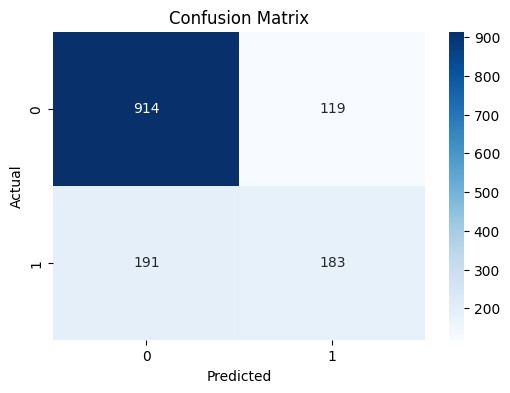

In [21]:
# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **Refine Model**

In [ ]:
# Parameter Grid
params = {
    'n_estimators':[100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

# Run grid search cross validation
grid_search = GridSearchCV(    
    estimator=RandomForestClassifier(random_state=42),
    param_grid=params,
    scoring='recall',
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

Best parameters: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}


In [23]:
# Test with refined model
y_pred_refined = best_model.predict(X_test)
y_pred_proba_refined = best_model.predict_proba(X_test)[:, 1]

# Check ROC-AUC of probabilities
roc_auc = roc_auc_score(y_test, y_pred_proba_refined)
print(f"ROC-AUC: {roc_auc}")

ROC-AUC: 0.839572192513369


In [24]:
# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_refined))

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.70      0.79      1033
           1       0.50      0.81      0.62       374

    accuracy                           0.73      1407
   macro avg       0.70      0.76      0.70      1407
weighted avg       0.80      0.73      0.75      1407



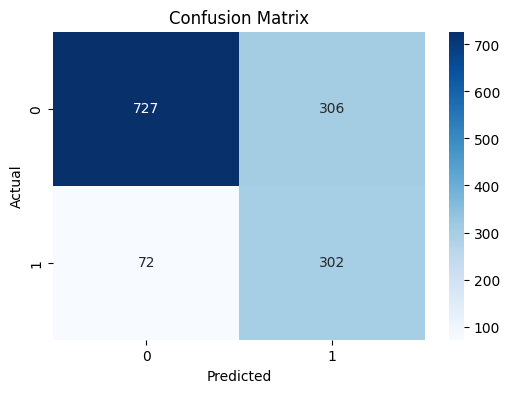

In [26]:
# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_refined)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### **Precision-Recall Curve**

In [27]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_refined)
avg_precision = average_precision_score(y_test, y_pred_proba_refined)

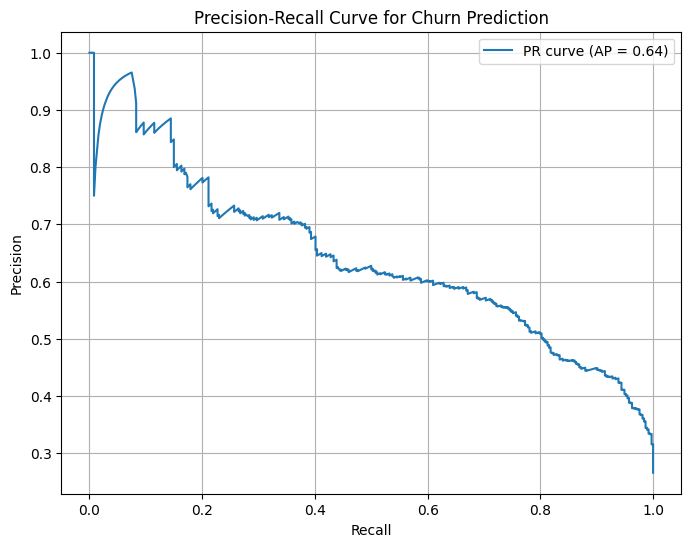

In [28]:
plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Churn Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
# Get optimal cutoff threshold for model
f1_scores = 2 * (precision * recall) / (precision + recall)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]

print(f"Best F1 = {f1_scores[best_index]:.3f} at threshold = {best_threshold:.2f}")

Best F1 = 0.635 at threshold = 0.58


In [30]:
y_pred_opt = (best_model.predict_proba(X_test)[:,1] >= best_threshold).astype(int)

In [31]:
print("ROC-AUC: ", roc_auc_score(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt))

ROC-AUC:  0.7637197094802014
              precision    recall  f1-score   support

           0       0.89      0.78      0.84      1033
           1       0.55      0.74      0.64       374

    accuracy                           0.77      1407
   macro avg       0.72      0.76      0.74      1407
weighted avg       0.80      0.77      0.78      1407



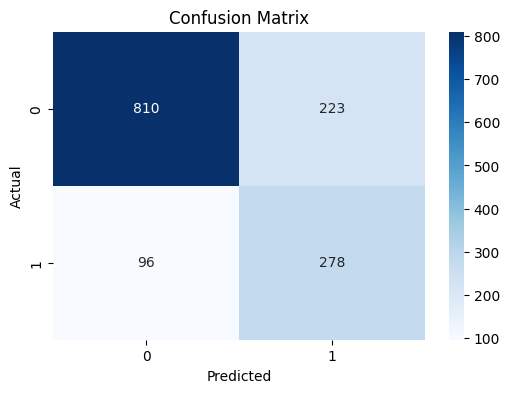

In [32]:
# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_opt)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()